In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
from common.utils.pickling import pickle_read
from common.utils.misc import load_samples, load_sample_loss_csv, load_sample_losses
import matplotlib.pyplot as plt


In [2]:
def load_losses(path):
    p_losses = Path(path) / 'val_sample_loss_all.pkl'
    if not p_losses.exists():
        return None
    data = pickle_read(p_losses)
    for d in data['sample_losses'].values():
        d['wloss'] = (d['loss']*d['flows'])/d['flows'].sum()
    print(f'losses loaded, best epoch: {min(data["epoch_losses"].items(), key=lambda x: x[1])}')
    return data

def val_loss(df):
    return (df.loss*df.flows).sum()/df.flows.sum()

def sample_loss(df):
    return df.loss.mean()

def cv1out(df, loss_fn):
    cvlosses = []
    for i in df.index.values:
        idd = df.drop(i, axis=0)
        cvlosses.append(loss_fn(idd))
    
    cvloss = np.mean(cvlosses)
    return cvloss
    

#### load oracle loss

In [3]:
# load oracle losses
#p_oracle_losses = '/mnt/ext/shared/Projects/GNNetworkingChallenge/trained_oracle_models/6.23/losses_47-6.23/val_sample_loss_47-6.23.csv'
p_oracle_losses = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/trained_oracle_models/6.33/losses_09-6.33/val_sample_loss_09-6.33.csv'
ora_loss = load_sample_losses(loss_files=[Path(p_oracle_losses)])
print('loaded files: ')
print(ora_loss.loss_file.unique())
ora_wloss = ora_loss.sort_values(by='wloss', ascending=False).reset_index()
ora_loss = ora_loss.sort_values(by='loss', ascending=False).reset_index()
ora_wloss.head()

loaded files: 
['val_sample_loss_09-6.33.csv']


,index,path,loss,flows,net_size,wloss,dset,loss_file
0,101,/mnt/ext/shared/Projects/GNNetworkingChallenge...,16.679949,89700,300,0.313139,300,val_sample_loss_09-6.33.csv
1,90,/mnt/ext/shared/Projects/GNNetworkingChallenge...,16.209997,78120,280,0.265030,280,val_sample_loss_09-6.33.csv
2,59,/mnt/ext/shared/Projects/GNNetworkingChallenge...,19.922832,57360,240,0.239172,240,val_sample_loss_09-6.33.csv
3,68,/mnt/ext/shared/Projects/GNNetworkingChallenge...,18.905764,57360,240,0.226962,240,val_sample_loss_09-6.33.csv
4,61,/mnt/ext/shared/Projects/GNNetworkingChallenge...,17.931301,57360,240,0.215264,240,val_sample_loss_09-6.33.csv


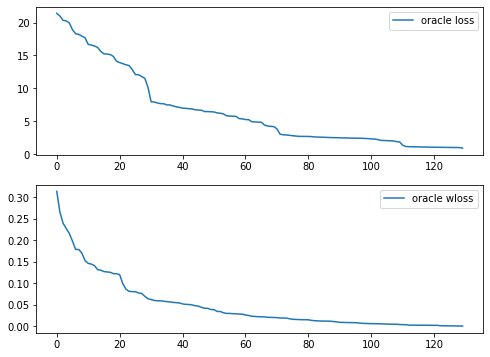

In [4]:
f, axx = plt.subplots(2,1, figsize=(8,6))
ora_loss.loss.plot(ax=axx[0], label='oracle loss')
axx[0].legend()
ora_wloss.wloss.plot(ax=axx[1], label='oracle wloss')
axx[1].legend()

In [5]:
ora_groups = {
    'l-top10': ora_loss.iloc[:10],
    'l-top30': ora_loss.iloc[:30],
    'l-30-80': ora_loss.iloc[30:80],
    'wl-top10': ora_wloss.iloc[:10],
    'wl-top20': ora_loss.iloc[:20],
    'wl-20-80': ora_loss.iloc[20:80],
}


#### calculate metrics for each run

In [6]:
models = {'e6.71_A_sub': '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/submissions/2/Exp#10_2022-10-08__00-06-28',
          'e6.70_A': '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/submissions/c3/Exp#34_2022-10-08__14-44-29',
          'y6.675_fr_sub': '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/submissions/3/n_3_0_2022-10-12__09-56-16',
          'y6.88_fr': '/mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3/friends_6.7/repl_easiest_with_1hardest_x_n/h_7_n_2_2/h_7_n_2_2_2022-10-11__21-42-56',
          'y7.02_fr': '/mnt/ext-10g/users/yakovl/dev/GNNetworkingChallenge/subset_training/unshuffled_order/3/friends_6.7_2/repl_hardest_with_friends/n_5_2/n_5_2_2022-10-12__09-56-16',
          'e6.8936_C': '/mnt/ext/users/eliyahus/Projects/Simulations/Datacom/GNNC22/NoShuffle/clustering/min_dist/6_33/topk#5/Exp#129_2022-10-13__05-38-49',
          'e6.9573_C': '/mnt/ext/users/eliyahus/Projects/Simulations/Datacom/GNNC22/NoShuffle/clustering/min_dist/6_33/topk#5/Exp#132_2022-10-13__05-38-54',
          'e6.9651_C': '/mnt/ext/users/eliyahus/Projects/Simulations/Datacom/GNNC22/NoShuffle/clustering/min_dist/6_33/topk#5/Exp#68_2022-10-13__04-35-56',
          'e7.0019_C': '/mnt/ext/users/eliyahus/Projects/Simulations/Datacom/GNNC22/NoShuffle/clustering/min_dist/6_33/topk#5/Exp#116_2022-10-13__05-38-01',
          'e7.1031_C': '/mnt/ext/users/eliyahus/Projects/Simulations/Datacom/GNNC22/NoShuffle/clustering/min_dist/6_33/topk#5/Exp#63_2022-10-13__04-35-54',
          'e6.95_E': '/mnt/ext/users/eliyahus/Projects/Simulations/Datacom/GNNC22/NoShuffle/random_replace/random_replace_hards/Phase#21/Exp#4_2022-10-12__03-05-24',
         }

In [7]:
results = {}
best = {}
mall = []
for name, path in models.items():
    data = load_losses(path)
    if data is None or len(data['sample_losses'][1])==0:
        continue
    metrics = []
    for ep, ep_loss in data['epoch_losses'].items():
        smp_losses = data['sample_losses'][ep]
        imetrics = {'epoch': ep, 
                    'loss': ep_loss, 
                    'mean_smp_loss': sample_loss(smp_losses),
                    # 'cv1_wloss': cv1out(smp_losses, val_loss),
                   }

        for k, iora in ora_groups.items():
            ismp = smp_losses[smp_losses.path.isin(iora.path)]
            imetrics['loss_' + k] = sample_loss(ismp)

        metrics.append(imetrics)

    metrics = pd.DataFrame(metrics)
    metrics['name'] = name + '_' + metrics.epoch.astype(str)
    metrics = pd.DataFrame(metrics).set_index('epoch', drop=True)
    
    ibest = metrics.min()
    best[name] = ibest
    results[name] = {
        'name': name,
        'path': path,
        'data': data,
        'metrics': metrics,
        'best': ibest
    }

best = pd.DataFrame(best)
    

losses loaded, best epoch: (16, 6.707363605499268)
losses loaded, best epoch: (20, 6.8827)
losses loaded, best epoch: (15, 7.0155)
losses loaded, best epoch: (12, 6.8936)
losses loaded, best epoch: (18, 6.9573)
losses loaded, best epoch: (19, 6.9651)
losses loaded, best epoch: (19, 7.0019)
losses loaded, best epoch: (17, 7.1031)
losses loaded, best epoch: (11, 6.9511)


In [8]:
print('best metric by model')
best.drop('name')

best metric by model


,e6.71_A_sub,y6.88_fr,y7.02_fr,e6.8936_C,e6.9573_C,e6.9651_C,e7.0019_C,e7.1031_C,e6.95_E
loss,6.707364,6.8827,7.0155,6.8936,6.9573,6.9651,7.0019,7.1031,6.9511
mean_smp_loss,7.067063,7.279192,7.31056,7.381564,7.25205,7.421224,7.481372,7.564061,7.412244
loss_l-top10,21.927345,22.712065,22.054159,22.143695,21.517628,22.731745,23.891113,22.335964,24.083776
loss_l-top30,18.110234,18.378013,17.929295,18.935561,17.733263,18.913132,19.785087,18.670323,19.728084
loss_l-30-80,5.61415,5.968023,5.813489,5.885899,5.79282,5.826409,5.585437,5.773472,5.722828
loss_wl-top10,19.564531,19.828507,19.650354,19.548706,19.330141,20.226987,21.548587,19.751619,21.452106
loss_wl-top20,19.801165,20.228056,19.755395,20.611448,19.365102,20.705406,21.639652,20.341264,21.527057
loss_wl-20-80,7.133188,7.419674,7.476513,7.546707,7.35777,7.410105,7.326559,7.332898,7.45738


In [9]:
print('best overall, with epoch')
dall = pd.concat([v['metrics'] for v in results.values()]).set_index('name')
pd.DataFrame({'epoch': dall.idxmin(), 'value': dall.min()})

best overall, with epoch


,epoch,value
loss,e6.71_A_sub_16,6.707364
mean_smp_loss,e6.71_A_sub_16,7.067063
loss_l-top10,e6.9573_C_17,21.517628
loss_l-top30,e6.9573_C_17,17.733263
loss_l-30-80,e7.0019_C_19,5.585437
loss_wl-top10,e6.9573_C_17,19.330141
loss_wl-top20,e6.9573_C_17,19.365102
loss_wl-20-80,e6.71_A_sub_16,7.133188


##### leftovers

In [3]:
#p_losses = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/submissions/c2/Exp#10_2022-10-08__00-06-28/val_sample_loss_all.pkl'
p_losses = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/submissions/c3/Exp#34_2022-10-08__14-44-29/val_sample_loss_all.pkl'

dall = pickle_read(p_losses)
for d in dall['sample_losses'].values():
    d['wloss'] = (d['loss']*d['flows'])/d['flows'].sum()
    
print(f'losses loaded, best epoch: {min(dall["epoch_losses"].items(), key=lambda x: x[1])}')

losses loaded, best epoch: (16, 6.698634147644043)


In [4]:
dall['sample_losses'][1].head()

,path,loss,flows,net_size,wloss
0,/mnt/ext/shared/Projects/GNNetworkingChallenge...,26.105803,9900,100,0.054091
1,/mnt/ext/shared/Projects/GNNetworkingChallenge...,6.112751,9900,100,0.012665
2,/mnt/ext/shared/Projects/GNNetworkingChallenge...,6.120851,9900,100,0.012682
3,/mnt/ext/shared/Projects/GNNetworkingChallenge...,11.918881,9900,100,0.024696
4,/mnt/ext/shared/Projects/GNNetworkingChallenge...,37.205624,9900,100,0.077089


In [9]:
metrics = []
for ep, ep_loss in dall['epoch_losses'].items():
    smp_losses = dall['sample_losses'][ep]
    imetrics = {'epoch': ep, 
                'loss': ep_loss, 
                'mean_smp_loss': sample_loss(smp_losses),
                'cv1_wloss': cv1out(smp_losses, val_loss),
               }
    
    for k, iora in ora_groups.items():
        ismp = smp_losses[smp_losses.path.isin(iora.path)]
        imetrics['loss_' + k] = sample_loss(ismp)
    
    metrics.append(imetrics)

metrics = pd.DataFrame(metrics).set_index('epoch', drop=True)
metrics

,loss,mean_smp_loss,cv1_wloss,loss_l-top10,loss_l-top30,loss_l-30-80,loss_wl-top10,loss_wl-top20,loss_wl-20-80
epoch,,,,,,,,,
1,14.306168,14.885670,14.306248,41.588665,34.854974,13.058676,34.826744,37.990374,15.646259
2,11.986910,12.533838,11.986978,35.594977,29.786752,10.780230,29.793262,32.502839,13.042621
3,11.922791,12.302605,11.922851,32.322791,27.791390,11.393579,27.868537,30.078823,13.364070
4,11.644386,11.883416,11.644425,27.301872,23.593969,11.334264,23.980004,25.435689,12.763642
5,10.559667,10.757554,10.559704,25.366167,21.845214,10.081025,22.135008,23.578378,11.464002
6,9.758158,9.925814,9.758190,23.588506,20.170273,9.758824,20.603895,21.708093,10.981459
7,8.098513,8.465531,8.098561,25.428093,20.765537,6.872965,21.034125,22.833227,8.499164
8,8.195141,8.373504,8.195179,23.646724,18.967899,7.530116,19.698913,20.851119,8.808673
9,8.027900,8.237904,8.027941,23.572198,19.319581,7.088035,20.082784,21.141544,8.519305


In [10]:
display(metrics)

,loss,mean_smp_loss,cv1_wloss,loss_l-top10,loss_l-top30,loss_l-30-80,loss_wl-top10,loss_wl-top20,loss_wl-20-80
epoch,,,,,,,,,
1,14.306168,14.885670,14.306248,41.588665,34.854974,13.058676,34.826744,37.990374,15.646259
2,11.986910,12.533838,11.986978,35.594977,29.786752,10.780230,29.793262,32.502839,13.042621
3,11.922791,12.302605,11.922851,32.322791,27.791390,11.393579,27.868537,30.078823,13.364070
4,11.644386,11.883416,11.644425,27.301872,23.593969,11.334264,23.980004,25.435689,12.763642
5,10.559667,10.757554,10.559704,25.366167,21.845214,10.081025,22.135008,23.578378,11.464002
6,9.758158,9.925814,9.758190,23.588506,20.170273,9.758824,20.603895,21.708093,10.981459
7,8.098513,8.465531,8.098561,25.428093,20.765537,6.872965,21.034125,22.833227,8.499164
8,8.195141,8.373504,8.195179,23.646724,18.967899,7.530116,19.698913,20.851119,8.808673
9,8.027900,8.237904,8.027941,23.572198,19.319581,7.088035,20.082784,21.141544,8.519305
